In [100]:
import prophet
import pandas as pd
import os 
import numpy as np
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from fyenn_class import pd_loaddata

In [254]:
os.listdir()
df2 = pd_loaddata.pd_excel('./Question 2')
df2.columns = pd.Series(df2.columns).str.replace('\s|\W', '')
df2['CalendarDateYYYYMMDD'] = pd.to_datetime(df2['CalendarDateYYYYMMDD'].astype(str))

csv_read


C:\Users\DSCSHA~1\AppData\Local\Temp/ipykernel_8924/1940940017.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df2.columns = pd.Series(df2.columns).str.replace('\s|\W', '')


#### price never changed in these years.

<AxesSubplot:xlabel='Price', ylabel='Count'>

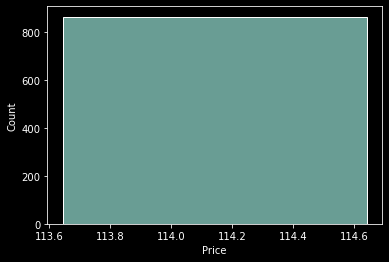

In [31]:
sns.histplot(df2['Price'])

#### too many 0s in inventory column

<AxesSubplot:xlabel='InventoryUnit', ylabel='Count'>

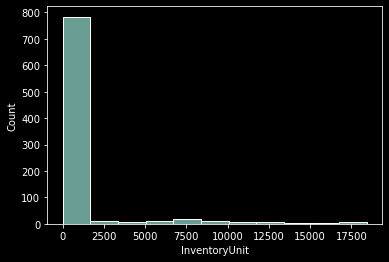

In [27]:
sns.histplot(df2['InventoryUnit'])

Text(0.5, 1.0, 'Col1 x Col2')

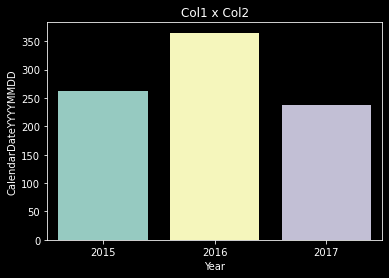

In [49]:
pltyear = pd.DataFrame(df2.groupby('Year', as_index=False).agg(
    {
        'CalendarDateYYYYMMDD': 'nunique',
        'SalesAmount':'sum',
        'SoldUnit':'sum'

    }
))
# pltyear
sns.barplot(x = pltyear.Year, y = pltyear.CalendarDateYYYYMMDD).set_title('year vs count_line')

<AxesSubplot:xlabel='Year', ylabel='SalesAmount'>

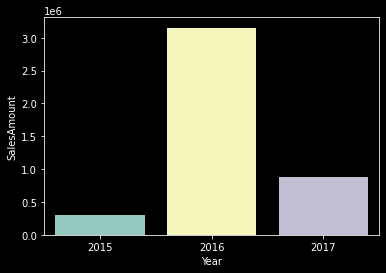

In [48]:
sns.barplot(x = pltyear.Year, y = pltyear.SalesAmount).set_title('year vs sum_sales')

Text(0.5, 1.0, 'year vs SoldUnit')

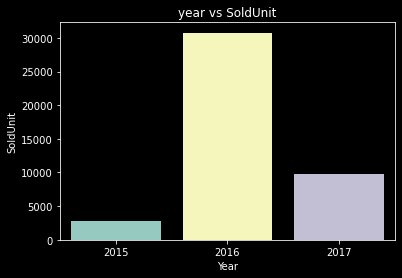

In [50]:
sns.barplot(x = pltyear.Year, y = pltyear.SoldUnit).set_title('year vs SoldUnit')

Text(0.5, 1.0, 'year vs SoldUnit')

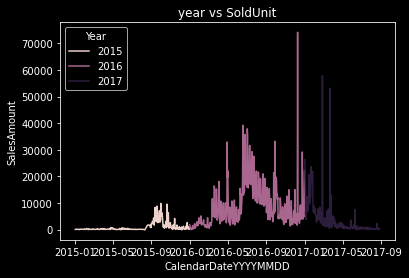

In [54]:
sns.lineplot(x = df2.CalendarDateYYYYMMDD, y = df2.SalesAmount, hue = df2.Year).set_title('horizon sales')

Text(0.5, 1.0, 'horizon sales')

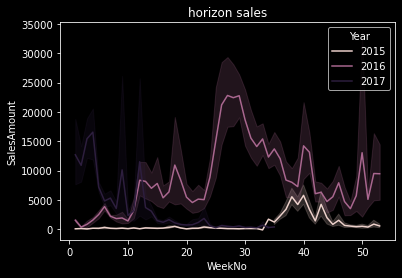

In [63]:
sns.lineplot(x = 'WeekNo', y = 'SalesAmount', hue = 'Year', data=df2).set_title('annually comparison sales')
# fig.lineplot(x = 'CalendarDateYYYYMMDD', y = 'SalesAmount', data=df2)

#### 2016 has shown significant larger sales amount than other years, and several sales amount too high or too low would be removed in the model training process to keep robustness.
#### 2015 has lost some days' data, this would be auto filled with previous day value in the model training process.

In [375]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet
from prophet.diagnostics import cross_validation ,performance_metrics

# os.listdir()
df2 = pd_loaddata.pd_excel('./Question 2')
df2.columns = pd.Series(df2.columns).str.replace('\s|\W', '')
df2['CalendarDateYYYYMMDD'] = pd.to_datetime(df2['CalendarDateYYYYMMDD'].astype(str))
df2.head(2)

csv_read


C:\Users\DSCSHA~1\AppData\Local\Temp/ipykernel_8924/1526549198.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df2.columns = pd.Series(df2.columns).str.replace('\s|\W', '')


,Year,CalendarDateYYYYMMDD,WeekNo,Year_Week,Price,SalesAmount,SoldUnit,InventoryUnit
0,2015,2015-01-02,1,2015_01,114.142857,68.428640,1,0
1,2015,2015-01-03,1,2015_01,114.142857,85.571514,1,0


In [376]:
sc1= MinMaxScaler()
df2['SalesAmount'] = sc1.fit_transform(np.array(df2['SalesAmount']).reshape(-1,1))
def ppr_(df2):   
    df2 = df2.rename({'CalendarDateYYYYMMDD' : 'ds', 'SalesAmount': 'y'}, axis = 1)
    df2.index = df2.ds
    df2 = df2.asfreq('D')
    df2['ds'] = df2.index
    df2 = df2.ffill()
    # return TimeSeriesSplit(df2[['ds', 'y']], test_size=.2)
    return df2 
x_train = ppr_(df2)
# col = ['SoldUnit', 'InventoryUnit']
# x_train, x_test = ppr_(df2)

#### timeseries cross validation with every 90 days, since the plots above showed a pattern in such way.

In [377]:
%%time

x_train['cap'] = 1
x_train['floor'] = 0
rmses = []
MAPE = []
# x_test['cap'] = 1
m = Prophet(growth='logistic')
m.add_country_holidays(country_name='CN')
# [m.add_regressor(i) for i in col]
# m.fit(x_train)
# prd = m.predict(x_test)['yhat']
fp = x_train['ds'][round(x_train.shape[0]*.25)] - x_train['ds'].min()
df_cv = cross_validation(m.fit(x_train), initial=fp, period='90 days', horizon = '180 days')
df_p = performance_metrics(df_cv, rolling_window=1)

# prd_bk = prd

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 7 forecasts with cutoffs between 2015-09-07 00:00:00 and 2017-02-28 00:00:00
100%|██████████| 7/7 [00:48<00:00,  6.89s/it]
INFO:prophet:Skipping MAPE because y close to 0


Wall time: 51.3 s


---
### model performance summary

In [415]:
s2 = df_p.style.applymap(lambda x: 'opacity: 10%;color:red' if (type(x) == float) and (x > 1) else 'opacity: 20%;color:yellow;' )
        
        
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'tr:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #000066; color: white;'
}
# data = data.style.format(precision=0)

s2.background_gradient(axis=None, vmin=0, vmax=1000, cmap="YlGnBu")

,horizon,mse,rmse,mae,mdape,smape,coverage
0,180 days,0.042956,0.207259,0.159361,1.127251,1.267833,0.113492


### best performance is not ideal, smape 1.268  & rmse = .207. many features are not  taken into consideration, hence add more features would import the performance in the future.

In [370]:
%%capture 
# prd = prd_bk
# def mut_0(prd, qt):
#     if qt == 0:
#         return np.where(prd<0,0, prd)
#     else:
#         return np.where(prd<0, (np.abs(prd) + np.quantile(prd, qt))/2, prd)
# def evaluate_(prd):
#     prd_t = sc1.inverse_transform(prd.reshape(-1,1))
#     test_t = sc1.inverse_transform(np.array(x_test['y']).reshape(-1,1))
#     print(' mape\n',
#     mean_absolute_percentage_error(x_test['y'], prd), 
#     '\n mae \n',
#     mean_absolute_error(test_t, prd_t))
# prd = mut_0(prd, .25)
# evaluate_(prd)

In [372]:
%%capture 

# %%time

 
# m = Prophet(growth='logistic',daily_seasonality=True)
# m.add_country_holidays(country_name='CN')
# # [m.add_regressor(i) for i in col]
# m.fit(x_train)
# prd = m.predict(x_test)['yhat']
# prd_bk = prd

In [397]:
%%capture 
%%time
future = m.make_future_dataframe(periods = 180)
future['floor'] = 0
future['cap'] = 1
forecast = m.predict(future)
# forecast = forecast.rename(columns = {
#    'yhat': 'yhat_' + g
# })
# final = pd.merge(final, forecast.set_index('ds'), how = 'outer', left_index = True, right_index = True)

# final = final[['yhat_' + g
#    for g in grouped.groups.keys()
# ]]

Wall time: 13.2 s


In [398]:
%%capture 
submit = forecast[['ds','yhat']]
submit['yhat'] = sc1.inverse_transform(submit['yhat'].to_numpy().reshape(-1,1))

C:\Users\DSCSHA~1\AppData\Local\Temp/ipykernel_8924/2107383318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['yhat'] = sc1.inverse_transform(submit['yhat'].to_numpy().reshape(-1,1))


In [400]:
submit[submit['ds'] > x_train['ds'].max()].reset_index(drop=True)\
    # .to_csv('./dataup/submit.csv', index = None)

,ds,yhat
0,2017-08-28,5573.591565
1,2017-08-29,5481.891304
2,2017-08-30,6227.031874
3,2017-08-31,5374.330280
4,2017-09-01,6834.360204
...,...,...
175,2018-02-19,2686.820541
176,2018-02-20,2587.520184
177,2018-02-21,3338.957170
178,2018-02-22,2503.280678
